## Importing libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
print(tf.__version__)

2.6.0


In [4]:
from sklearn.ensemble import RandomForestRegressor

## Dataset

### Getting the dataset

In [5]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
col_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=col_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

In [6]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


#### Checking dataset for missing values

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

The Horsepower attribute has 6 missing values. We will exclude all the datapoints with a missing value in them.

In [8]:
#Dropping missing values
dataset = dataset.dropna()

#### Checking the type of attributes.

In [9]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
MPG,392.0,23.445918,7.805007,9.0,17.000,22.75,29.000,46.6
Cylinders,392.0,5.471939,1.705783,3.0,4.000,4.00,8.000,8.0
Displacement,392.0,194.411990,104.644004,68.0,105.000,151.00,275.750,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.50,126.000,230.0
Weight,392.0,2977.584184,849.402560,1613.0,2225.250,2803.50,3614.750,5140.0
Acceleration,392.0,15.541327,2.758864,8.0,13.775,15.50,17.025,24.8
Model Year,392.0,75.979592,3.683737,70.0,73.000,76.00,79.000,82.0
Origin,392.0,1.576531,0.805518,1.0,1.000,1.00,2.000,3.0


##### Converting Categorical Attributes to Dummy Variables

In [10]:
# Origin is Categorical
dataset['Origin'] = dataset['Origin'].map({1: '1', 2: '2', 3: '3'})
dataset = pd.get_dummies(dataset, columns=['Origin'])
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,0,0


### Preparing data

In [11]:
# Creating train-test split
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

#### Normalizing data

In [12]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Origin_1,0.624204,0.485101
Origin_2,0.178344,0.383413
Origin_3,0.197452,0.398712


In [13]:
# making a normalization layer
normalizer = tf.keras.layers.Normalization(axis = -1)
normalizer.adapt(np.array(train_dataset))

## Training and Prediction

In [14]:
# Dictionary for storing comparative performances of models
test_results = {}

# method for plotting loss function
def plot_loss(history, title):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.title(title)
  plt.legend()
  plt.grid(True)

### Linear Regression

In [15]:
# Defining Linear Regression Model
linear_regression_model = tf.keras.Sequential([
  normalizer,
  layers.Dense(units=1)                                               
])

# Compiling Model
linear_regression_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [16]:
# Fitting the model on training data
linear_regression_history = linear_regression_model.fit(
    train_dataset,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

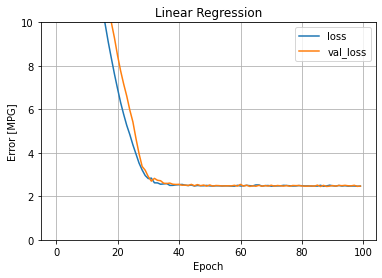

In [17]:
plot_loss(linear_regression_history, 'Linear Regression')

In [18]:
test_results['linear_regression_model'] = linear_regression_model.evaluate(
    test_dataset, test_labels, verbose=0
)

### Dense Layered Neural Network
Architecture -> normalization_layer || Dense(32, Relu) || Dense(64, Relu) || Dense(32, Relu) || Dense(1)

In [19]:
def build_model(norm):
  model = keras.Sequential([
          norm,
          layers.Dense(32, activation='relu'),
          layers.Dense(64, activation='relu'),
          layers.Dense(32, activation='relu'),
          layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
    optimizer=tf.keras.optimizers.Adam(0.001)
  )
  return model

In [20]:
dense_model= build_model(normalizer)
dense_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,564
Trainable params: 4,545
Non-trainable params: 19
_________________________________________________________________


In [21]:
# Fitting the model on training data
dense_model_history = dense_model.fit(
    train_dataset,
    train_labels,
    validation_split=0.2,
    verbose=0, 
    epochs=100
)

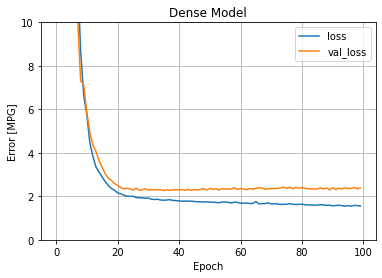

In [22]:
plot_loss(dense_model_history, 'Dense Model')

In [23]:
test_results['dense_model'] = dense_model.evaluate(
    test_dataset, test_labels, verbose=0
)

### Random Forest Regression 

In [24]:
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(train_dataset, train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [25]:
y_test_pred = regr.predict(test_dataset)

## Comparing the results of all models

In [26]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_regression_model,2.488503
dense_model,1.698037


In [27]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_labels, y_test_pred)

1.8117917453375831